# Make figures and examples for dependence metric calculation

This notebook uses simulated T2*/S0 manipulations to show how TE-dependence is leveraged to denoise multi-echo data.

The equation for how signal is dependent on changes in S0 and T2*:
$$S(t, TE_k) = \bar{S}(TE_k) * (1 + \frac{{\Delta}{S_0}(t)}{\bar{S}_0} - {\Delta}{R_2^*}(t)*TE_k)$$

In [1]:
%matplotlib inline
import os
import os.path as op

import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image
from matplotlib.animation import FuncAnimation
from nilearn.glm import first_level
from scipy import signal

sns.set_style("whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})

/Users/taylor/Documents/tsalo/nilearn/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
def pred_signal(echo_times, s0, t2s):
    """
    Predict multi-echo signal from S0, T2*, and echo
    times (in ms) according to monoexponential decay model.
    
    This is meant to be a sort of inverse to the code used
    in tedana.decay.fit_decay
    """
    if not isinstance(t2s, np.ndarray):
        t2s = np.array([t2s])

    if not isinstance(s0, np.ndarray):
        s0 = np.array([s0])

    neg_tes = (-1 * echo_times)[None, :]
    r2s = (1 / t2s)[:, None]
    intercept = np.log(s0)[:, None]
    log_data = np.dot(r2s, neg_tes) + intercept
    # Removed -1 from outside exp because it messes up dt_sig2
    data = np.exp(log_data).T
    return data


def pred_loglinear(data, echo_times):
    log_data = np.log(np.abs(data) + 1)


def compute_metrics(data, B, tes):
    tes = tes[:, None]
    data = data[None, ...]
    B = B[:, None]
    n_echos = len(tes)
    alpha = (np.abs(B)**2).sum(axis=0)
    mu = np.mean(data, axis=-1)
    X1 = mu.T  # Model 1
    X2 = np.tile(tes, (1, 1)) * mu.T  # Model 2

    # S0 Model
    # (S,) model coefficient map
    coeffs_S0 = (B * X1).sum(axis=0) / (X1**2).sum(axis=0)
    pred_S0 = X1 * np.tile(coeffs_S0, (n_echos, 1))
    SSE_S0 = (B - pred_S0)**2
    SSE_S0 = SSE_S0.sum(axis=0)  # (S,) prediction error map
    F_S0 = (alpha - SSE_S0) * (n_echos - 1) / (SSE_S0)

    # R2 Model
    coeffs_R2 = (B * X2).sum(axis=0) / (X2**2).sum(axis=0)
    pred_R2 = X2 * np.tile(coeffs_R2, (n_echos, 1))
    SSE_R2 = (B - pred_R2)**2
    SSE_R2 = SSE_R2.sum(axis=0)
    F_R2 = (alpha - SSE_R2) * (n_echos - 1) / (SSE_R2)
    
    return F_S0, F_R2, pred_S0, pred_R2
    

In [3]:
# Constants
OUT_DIR = '../docs/_static/'

# Simulate data
# For a nice, smooth curve
echo_times = np.arange(0, 101, 1)

# logan's TEs
# echo_times = np.array([9.58, 21.95, 34.32, 46.69, 59.06, 71.43, 83.8, 96.17])

# dan's TEs
#echo_times = np.array([15.4, 29.7, 44.0, 58.3, 72.6])

n_echoes = len(echo_times)
pal = sns.color_palette('cubehelix', 8)

# Simulate $T_{2}^{*}$ and $S_{0}$ fluctuations

In [4]:
# Simulate data
# We'll convolve with HRF just for smoothness
hrf = first_level.spm_hrf(1, oversampling=1)

n_trs = 11

frac = 0.1  # used to scale standard deviation
mean_t2s = 35
mean_s0 = 16000

# simulate the T2*/S0 time series 
ts = np.random.normal(loc=0, scale=1, size=(n_trs+20,))
ts = signal.convolve(ts, hrf)[20:n_trs+20]
ts *= frac / np.std(ts)
ts -= np.mean(ts)

t2s_ts = (ts * mean_t2s) + mean_t2s
s0_ts = (ts * mean_s0) + mean_s0

# Plot BOLD signal decay

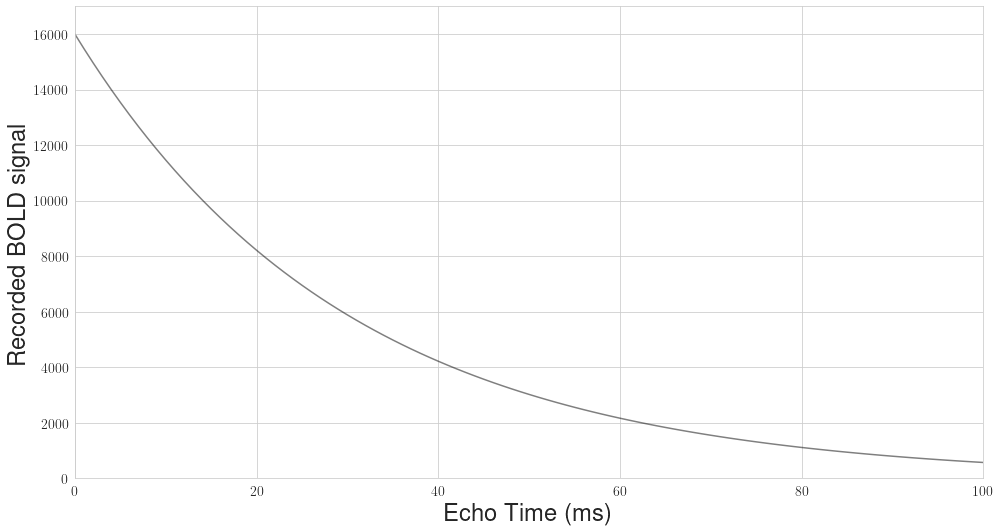

In [5]:
multiecho_signal = pred_signal(echo_times, np.full(n_trs, mean_s0), [30])

fig, ax = plt.subplots(figsize=(14, 7.5))
ax.plot(
    echo_times, 
    multiecho_signal[:, 0], 
    alpha=0.5,
    color="black",
)

ax.set_ylabel("Recorded BOLD signal", fontsize=24)
ax.set_xlabel("Echo Time (ms)", fontsize=24)
ax.set_ylim(0, np.ceil(np.max(multiecho_signal) / 1000) * 1000)
ax.set_xlim(0, np.max(echo_times))
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()

# save frame
fig.savefig(op.join(OUT_DIR, "physics_signal_decay.png"))

# Plot $T_{2}^{*}$ fluctuations and their effect on BOLD signal decay

In [6]:
multiecho_signal = pred_signal(echo_times, np.full(n_trs, mean_s0), t2s_ts)
acquired_echo_times = np.array([15, 30, 45, 60, 75, 90])
acquired_signal = multiecho_signal[acquired_echo_times, :]

out_file = op.join(OUT_DIR, "fluctuations_t2star.gif")
if op.isfile(out_file):
    os.remove(out_file)

filenames = []

for i_vol in range(n_trs):
    filename = f"t2s_{i_vol}.png"
    fig, axes = plt.subplots(
        nrows=2, 
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [1, 3]}
    )
    
    axes[0].plot(t2s_ts, color="black")
    axes[0].scatter(
        i_vol, 
        t2s_ts[i_vol], 
        color="blue",
        s=150,
    )
    axes[0].set_ylabel("$T_{2}^{*}$", fontsize=24)
    axes[0].set_xlabel("Volume", fontsize=24)
    axes[0].set_xlim(0, n_trs - 1)
    axes[0].tick_params(axis="both", which="major", labelsize=14)
    
    axes[1].plot(
        echo_times, 
        multiecho_signal[:, i_vol], 
        alpha=0.5,
        color="black",
    )
    axes[1].scatter(
        acquired_echo_times, 
        acquired_signal[:, i_vol], 
        color="blue",
        s=150,
        alpha=0.5,
    )
    axes[1].scatter(
        0, 
        mean_s0, 
        marker="*", 
        color="red", 
        s=500, 
        label="$S_{0}$",
        clip_on=False,
    )
    t2s_value = pred_signal(np.array([t2s_ts[i_vol]]), np.array([mean_s0]), np.array([t2s_ts[i_vol]]))[0]
    axes[1].scatter(
        t2s_ts[i_vol], 
        t2s_value, 
        marker="*", 
        color="blue", 
        s=500,
        label="$T_{2}^{*}$",
    )
    axes[1].legend(loc="upper right", fontsize=20)

    axes[1].set_ylabel("Recorded BOLD signal", fontsize=24)
    axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
    axes[1].set_xticks(acquired_echo_times)
    axes[1].set_ylim(0, np.ceil(np.max(multiecho_signal) / 1000) * 1000)
    axes[1].set_xlim(0, np.max(echo_times))
    axes[1].tick_params(axis="both", which="major", labelsize=14)
    fig.tight_layout()
    
    # save frame
    fig.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# build gif
with imageio.get_writer(out_file, mode="I") as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in filenames:
    os.remove(filename)

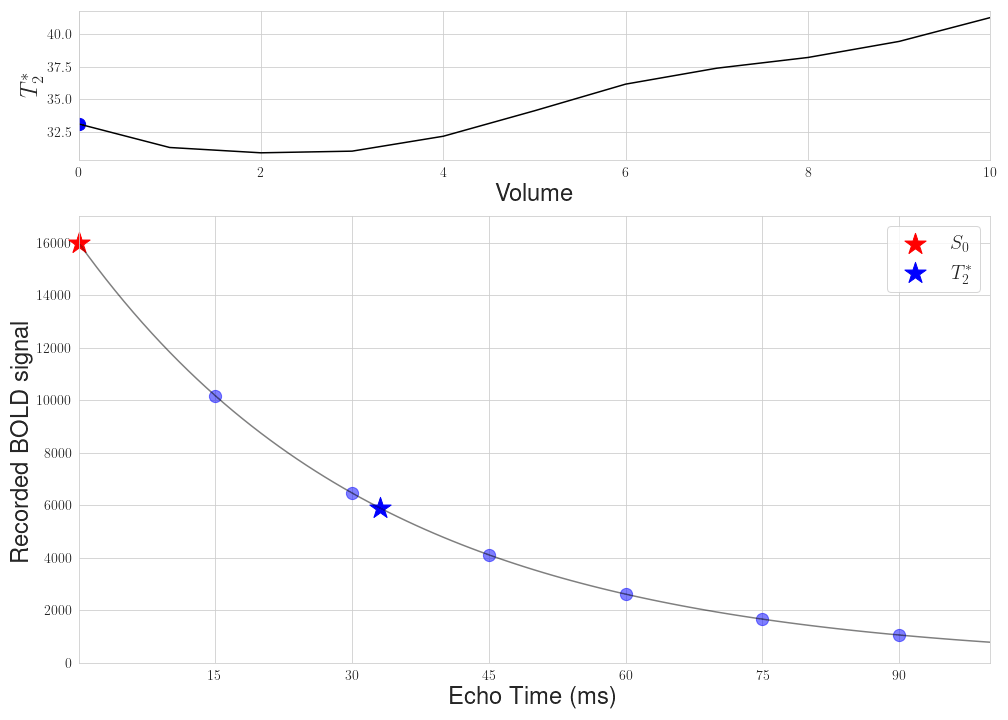

In [7]:
with open(out_file, "rb") as file:
    display(Image(file.read(), width=600))

In [8]:
out_file = op.join(OUT_DIR, "fluctuations_t2star_noline.gif")
if op.isfile(out_file):
    os.remove(out_file)

filenames = []

for i_vol in range(n_trs):
    filename = f"t2s_{i_vol}.png"
    fig, axes = plt.subplots(
        nrows=2, 
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [1, 3]}
    )
    
    axes[0].plot(t2s_ts, color="black")
    axes[0].scatter(
        i_vol, 
        t2s_ts[i_vol], 
        color="blue",
        s=150,
    )
    axes[0].set_ylabel("$T_{2}^{*}$", fontsize=24)
    axes[0].set_xlabel("Volume", fontsize=24)
    axes[0].set_xlim(0, n_trs - 1)
    axes[0].tick_params(axis="both", which="major", labelsize=14)
    
    axes[1].scatter(
        acquired_echo_times, 
        acquired_signal[:, i_vol], 
        color="blue",
        s=150,
        alpha=0.5,
    )

    axes[1].set_ylabel("Recorded BOLD signal", fontsize=24)
    axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
    axes[1].set_xticks(acquired_echo_times)
    axes[1].set_ylim(0, np.ceil(np.max(multiecho_signal) / 1000) * 1000)
    axes[1].set_xlim(0, np.max(echo_times))
    axes[1].tick_params(axis="both", which="major", labelsize=14)
    fig.tight_layout()
    
    # save frame
    fig.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# build gif
with imageio.get_writer(out_file, mode="I") as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in filenames:
    os.remove(filename)

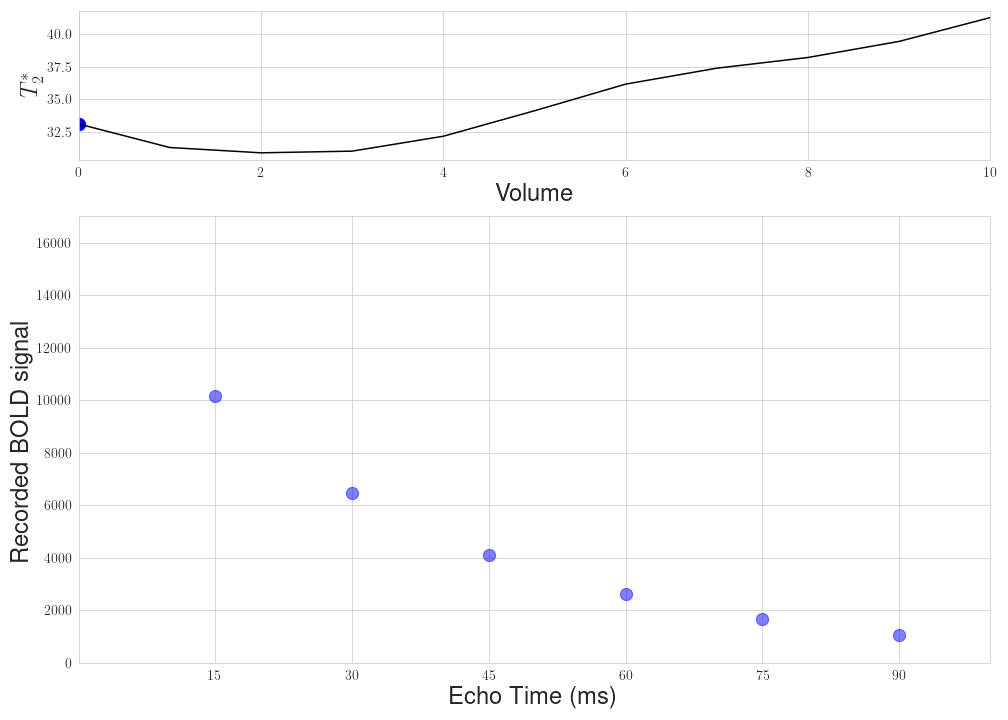

In [9]:
with open(out_file, "rb") as file:
    display(Image(file.read(), width=600))

## Plot $T_{2}^{*}$ against BOLD signal from single-echo data (TE=30ms)

<ipython-input-10-6291cf7193f9>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


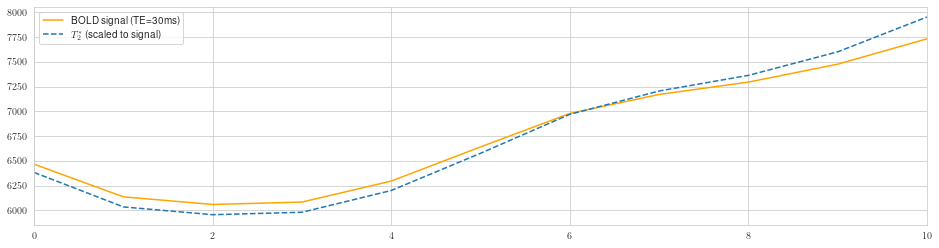

In [10]:
fig, ax = plt.subplots(figsize=(16, 4))

scalar = np.linalg.lstsq(t2s_ts[:, None], multiecho_signal[30, :], rcond=None)[0]
ax.plot(multiecho_signal[30, :], color="orange", label="BOLD signal (TE=30ms)")
ax.plot(t2s_ts * scalar, label="$T_{2}^{*}$ (scaled to signal)", linestyle="--")
ax.set_xlim(0, n_trs - 1)
leg = ax.legend()
fig.show()

# Plot $S_{0}$ fluctuations and their effect on BOLD signal decay

In [11]:
multiecho_signal = pred_signal(echo_times, s0_ts, np.full(n_trs, mean_t2s))
acquired_echo_times = np.array([15, 30, 45, 60, 75, 90])
acquired_signal = multiecho_signal[acquired_echo_times, :]

out_file = op.join(OUT_DIR, "fluctuations_s0.gif")
if op.isfile(out_file):
    os.remove(out_file)

filenames = []

for i_vol in range(n_trs):
    filename = f"s0_{i_vol}.png"
    fig, axes = plt.subplots(
        nrows=2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [1, 3]}
    )
    
    axes[0].plot(
        s0_ts, 
        color="black",
    )
    axes[0].scatter(
        i_vol, 
        s0_ts[i_vol], 
        color="red",
        s=150,
    )
    axes[0].set_ylabel("$S_{0}$", fontsize=24)
    axes[0].set_xlabel("Volume", fontsize=24)
    axes[0].set_xlim(0, n_trs - 1)
    axes[0].tick_params(axis="both", which="major", labelsize=14)
    
    axes[1].plot(
        echo_times, 
        multiecho_signal[:, i_vol], 
        alpha=0.5,
        color="black",
    )
    axes[1].scatter(
        acquired_echo_times, 
        acquired_signal[:, i_vol], 
        color="red",
        s=150,
        alpha=0.5,
    )
    axes[1].scatter(
        0, 
        s0_ts[i_vol], 
        marker="*", 
        color="red", 
        s=500, 
        label="$S_{0}$",
        clip_on=False,
    )
    axes[1].scatter(
        mean_t2s, 
        multiecho_signal[mean_t2s, i_vol], 
        marker="*", 
        color="blue", 
        s=500,
        label="$T_{2}^{*}$",
    )
    axes[1].legend(loc="upper right", fontsize=20)

    axes[1].set_ylabel("Recorded BOLD signal", fontsize=24)
    axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
    axes[1].set_xticks(acquired_echo_times)
    axes[1].set_ylim(0, np.ceil(np.max(multiecho_signal) / 1000) * 1000)
    axes[1].set_xlim(0, np.max(echo_times))
    axes[1].tick_params(axis="both", which="major", labelsize=14)
    fig.tight_layout()
    
    # save frame
    fig.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# build gif
with imageio.get_writer(out_file, mode="I") as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in filenames:
    os.remove(filename)

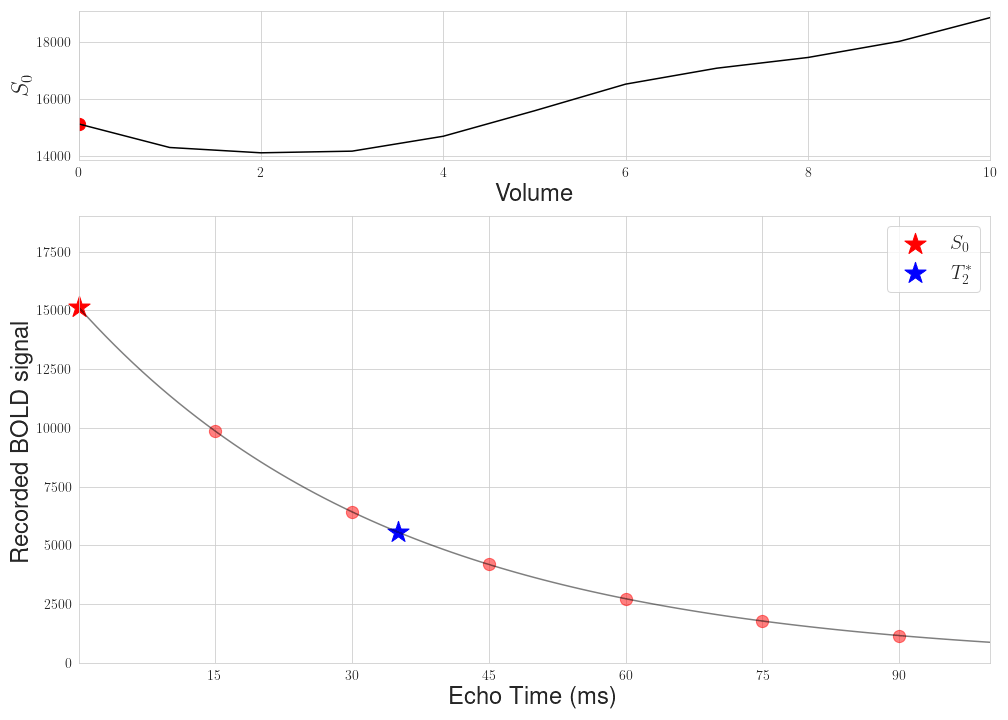

In [12]:
with open(out_file, "rb") as file:
    display(Image(file.read(), width=600))

In [13]:
out_file = op.join(OUT_DIR, "fluctuations_s0_noline.gif")
if op.isfile(out_file):
    os.remove(out_file)

filenames = []

for i_vol in range(n_trs):
    filename = f"s0_{i_vol}.png"
    fig, axes = plt.subplots(
        nrows=2, 
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [1, 3]}
    )
    
    axes[0].plot(s0_ts, color="black")
    axes[0].scatter(
        i_vol, 
        s0_ts[i_vol], 
        color="red",
        s=150,
    )
    axes[0].set_ylabel("$S_0$", fontsize=24)
    axes[0].set_xlabel("Volume", fontsize=24)
    axes[0].set_xlim(0, n_trs - 1)
    axes[0].tick_params(axis="both", which="major", labelsize=14)
    
    axes[1].scatter(
        acquired_echo_times, 
        acquired_signal[:, i_vol], 
        color="red",
        s=150,
        alpha=0.5,
    )

    axes[1].set_ylabel("Recorded BOLD signal", fontsize=24)
    axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
    axes[1].set_xticks(acquired_echo_times)
    axes[1].set_ylim(0, np.ceil(np.max(multiecho_signal) / 1000) * 1000)
    axes[1].set_xlim(0, np.max(echo_times))
    axes[1].tick_params(axis="both", which="major", labelsize=14)
    fig.tight_layout()
    
    # save frame
    fig.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# build gif
with imageio.get_writer(out_file, mode="I") as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in filenames:
    os.remove(filename)

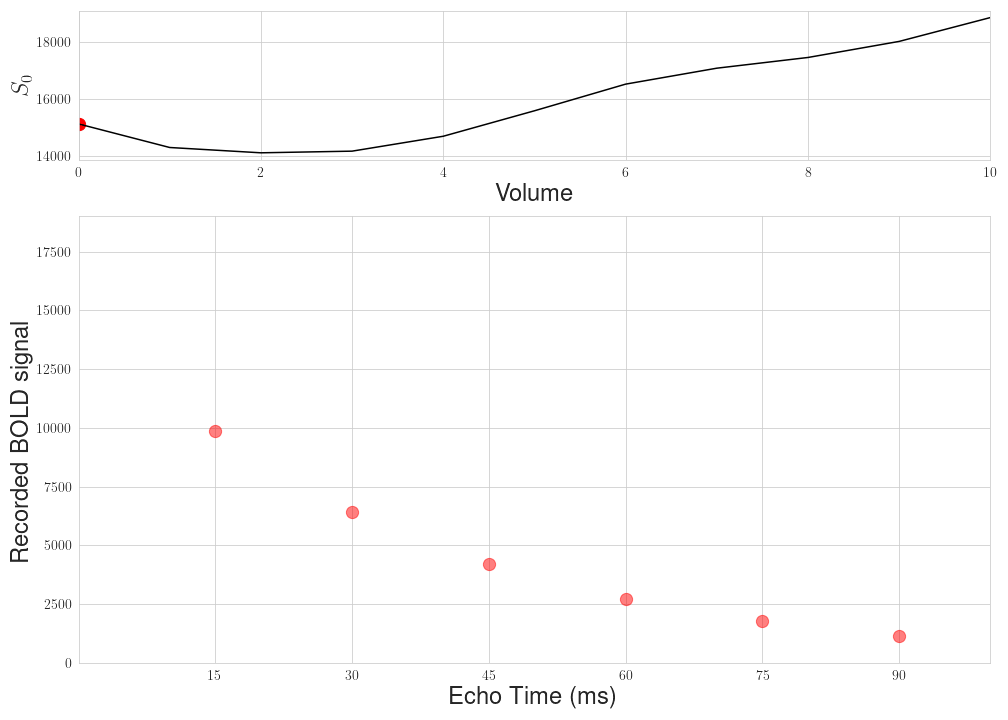

In [14]:
with open(out_file, "rb") as file:
    display(Image(file.read(), width=600))

## Plot $S_{0}$ against BOLD signal from single-echo data (TE=30ms)

<ipython-input-15-75175932ce0b>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


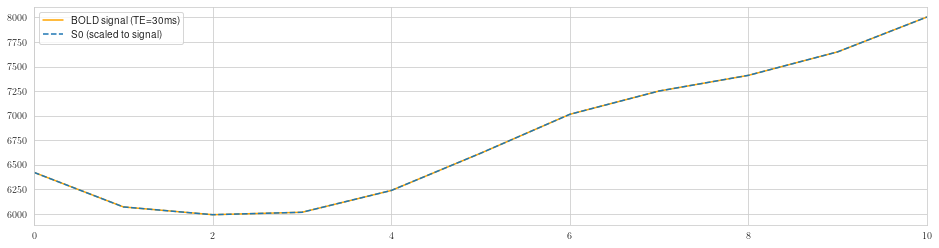

In [15]:
fig, ax = plt.subplots(figsize=(16, 4))

scalar = np.linalg.lstsq(s0_ts[:, None], multiecho_signal[30, :], rcond=None)[0]
ax.plot(multiecho_signal[30, :], color="orange", label="BOLD signal (TE=30ms)")
ax.plot(s0_ts * scalar, label="S0 (scaled to signal)", linestyle="--")
ax.set_xlim(0, n_trs - 1)
leg = ax.legend()
fig.show()

## Show how S0 and T2* fluctuations produce different patterns in multi-echo data

In [16]:
s0based_multiecho_signal = pred_signal(echo_times, s0_ts, np.full(n_trs, mean_t2s))
t2sbased_multiecho_signal = pred_signal(echo_times, np.full(n_trs, mean_s0), t2s_ts)
acquired_echo_times = np.array([15, 30, 45, 60, 75, 90])
s0based_acquired_signal = s0based_multiecho_signal[acquired_echo_times, :]
t2sbased_acquired_signal = t2sbased_multiecho_signal[acquired_echo_times, :]

out_file = op.join(OUT_DIR, "fluctuations_total.gif")
if op.isfile(out_file):
    os.remove(out_file)

filenames = []

for i_vol in range(n_trs):
    filename = f"total_{i_vol}.png"
    fig, axes = plt.subplots(
        nrows=2, 
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [1, 3]}
    )
    
    axes[0].plot(ts, color="black")
    axes[0].scatter(
        i_vol, 
        ts[i_vol], 
        color="purple",
        s=150,
    )
    axes[0].set_ylabel("$S_0$/$T_{2}^{*}$", fontsize=24)
    axes[0].set_xlabel("Volume", fontsize=24)
    axes[0].set_xlim(0, n_trs - 1)
    axes[0].tick_params(axis="both", which="major", labelsize=14)
    
    axes[1].scatter(
        acquired_echo_times, 
        s0based_acquired_signal[:, i_vol], 
        color="red",
        s=150,
        alpha=0.5,
        label="$S_0$ signal changes",
    )
    axes[1].scatter(
        acquired_echo_times, 
        t2sbased_acquired_signal[:, i_vol], 
        color="blue",
        s=150,
        alpha=0.5,
        label="$T_{2}^{*}$ signal changes",
    )
    axes[1].legend(loc="upper right", fontsize=20)

    axes[1].set_ylabel("Recorded BOLD signal", fontsize=24)
    axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
    axes[1].set_xticks(acquired_echo_times)
    axes[1].set_ylim(0, np.ceil(np.max(s0based_acquired_signal) / 1000) * 1000)
    axes[1].set_xlim(0, np.max(echo_times))
    axes[1].tick_params(axis="both", which="major", labelsize=14)
    fig.tight_layout()
    
    # save frame
    fig.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# build gif
with imageio.get_writer(out_file, mode="I") as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in filenames:
    os.remove(filename)

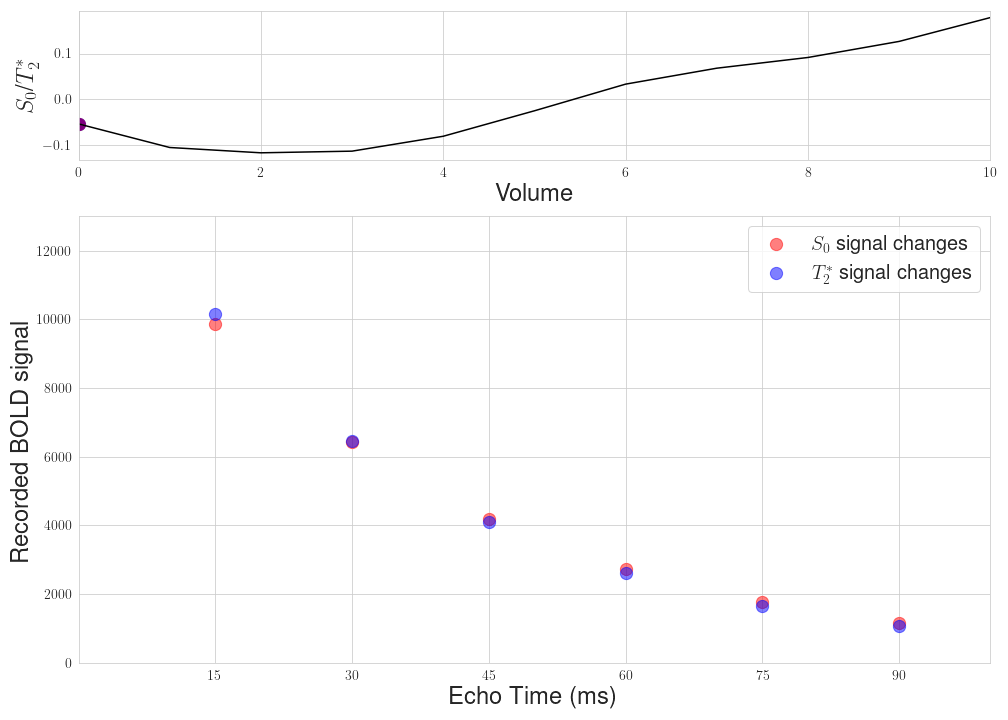

In [17]:
with open(out_file, "rb") as file:
    display(Image(file.read(), width=600))